In [12]:
import os.path
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import sklearn.svm
import sklearn.linear_model
import sklearn.ensemble

sys.path.append("../../")  # trick to import clairvoya from internal notebook directory
import clairvoya.runbench
import clairvoya.pulearning
import clairvoya.voya_plotter
import clairvoya.datasetup

%matplotlib inline

# Run Conditions

In [13]:
train_num_pos = 1000
train_num_unlab = 10000

test_num_all = 1000
test_num_pos_frac = 0.5

num_runs_per = 100

gamma_range = np.arange(0.1, 1., 0.1)
# gamma_range = (0.1, 0.5, 0.8)
K_range = [1, 5, 10]

# Distributions
Gaussian1_mean = [0,0]
Gaussian2_mean = [1,1]

Gaussian1_cov = [[1, 0.5], [0.5, 1]]
Gaussian2_cov = [[1, -0.5], [-0.5, 1]]

In [14]:
# Generate Gaussian Functions
Gaussian1 = lambda n_samp: np.random.multivariate_normal(Gaussian1_mean, Gaussian1_cov, n_samp)
Gaussian2 = lambda n_samp: np.random.multivariate_normal(Gaussian2_mean, Gaussian2_cov, n_samp)

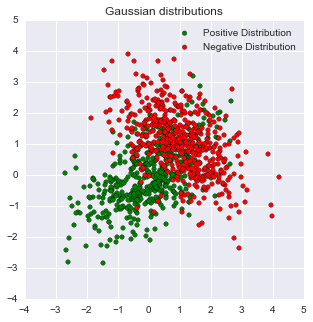

In [15]:
plot_samples = 500
plot_g1 = Gaussian1(plot_samples)
plot_g2 = Gaussian2(plot_samples)

fig = plt.figure(figsize=(5,5))
plt.scatter(plot_g1[:,0], plot_g1[:,1], c='green', label="Positive Distribution")
plt.scatter(plot_g2[:,0], plot_g2[:,1], c='red', label="Negative Distribution")
plt.title('Gaussian distributions')
plt.legend()

In [16]:
def generate_gaussian_features_array(Gaussian, num, label):
    data = Gaussian(num)
    label = np.ones(num) * label
    x_1 = data[:,0]
    x_2 = data[:,1]
    
    features_array = np.column_stack((label, label, x_1, x_2, x_1*x_2, x_1**2, x_2**2))
    return features_array

def generate_mixed_df(num_sample, frac_pos, global_label=None):
    num_pos = int(num_sample*frac_pos)
    num_neg = int(num_sample - num_pos)
    
    features_arr_pos = generate_gaussian_features_array(Gaussian1, num_pos, 1)
    features_arr_neg = generate_gaussian_features_array(Gaussian2, num_neg, 0)
    
    features_arr = np.vstack((features_arr_pos, features_arr_neg))
    mixed_df = pd.DataFrame(features_arr, columns=("fake_id", "label", "X_1", "X_2", "X_1 * X_2", "X_1**2", "X_2**2"))
    
    if global_label is not None:
        mixed_df['label'] = global_label
    
    return mixed_df

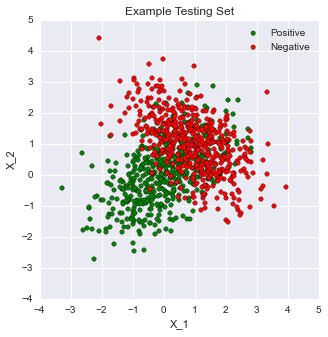

In [17]:
df = generate_mixed_df(test_num_all, 0.5)
fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
df[df["label"]==1].plot(kind="scatter", x="X_1", y="X_2", c='green', ax=ax1, label="Positive")
df[df["label"]==0].plot(kind="scatter", x="X_1", y="X_2", c='red', ax=ax1, label="Negative")
plt.title("Example Testing Set")

In [18]:
pd.value_counts(df[['label']].values.ravel()) # Sanity Check

1    500
0    500
dtype: int64

In [19]:
# Generate test data set
gamma = 0.5
train_unlabeled = generate_mixed_df(train_num_unlab, gamma, global_label=0)
train_positive = generate_mixed_df(train_num_pos, 1)
train_df = train_positive.append(train_unlabeled, ignore_index=True)
print pd.value_counts(train_df[['label']].values.ravel()) # Sanity Check
train_df.head()

0    10000
1     1000
dtype: int64


,fake_id,label,X_1,X_2,X_1 * X_2,X_1**2,X_2**2
0,1,1,-1.143973,-1.298404,1.485339,1.308674,1.685854
1,1,1,-0.841672,-1.723825,1.450895,0.708412,2.971571
2,1,1,-0.190025,0.547561,-0.104050,0.036109,0.299823
3,1,1,-0.819525,-0.221908,0.181859,0.671620,0.049243
4,1,1,-1.962488,-0.854552,1.677047,3.851359,0.730258


In [20]:
test_df = generate_mixed_df(test_num_all, test_num_pos_frac)
print pd.value_counts(test_df[['label']].values.ravel()) # Sanity Check
test_df.head()

1    500
0    500
dtype: int64


,fake_id,label,X_1,X_2,X_1 * X_2,X_1**2,X_2**2
0,1,1,1.753217,0.469802,0.823665,3.073770,0.220714
1,1,1,-0.313648,-2.261837,0.709421,0.098375,5.115908
2,1,1,0.178484,1.367409,0.244061,0.031857,1.869807
3,1,1,0.163844,0.721353,0.118190,0.026845,0.520350
4,1,1,-0.978131,-1.169702,1.144122,0.956741,1.368203


# Configuring the benchmark

In [21]:
auc_results = []
for gamma in gamma_range:
    run_results = []
    for i in xrange(num_runs_per):
        train_unlabeled = generate_mixed_df(train_num_unlab, gamma, global_label=0)
        train_positive = generate_mixed_df(train_num_pos, 1)
        train_df = train_positive.append(train_unlabeled, ignore_index=True)

        test_df = generate_mixed_df(test_num_all, test_num_pos_frac)


        config = {
            "test_df": test_df,  # instead of data_file, give split data
            "train_df": train_df,
            "out_path": None,
            "num_cores": 3,
            "verbosity": 0
        }

        LR_estimator = sklearn.linear_model.LogisticRegression(C=0.4, penalty='l1')

        classifiers = {
    #         'Bagging LR': sklearn.ensemble.BaggingClassifier(LR_estimator, n_estimators=200, max_samples=0.3)
            'Logistic Regression': sklearn.linear_model.LogisticRegression(),
        }

        classifiers_gridparameters = { # Gridsearch off
            'Bagging LR': None,
            'Logistic Regression': None,
        }

        results_dict = clairvoya.runbench.run_benchmark(config, classifiers, classifiers_gridparameters)
    
        run_results.append(results_dict['Logistic Regression']['auc_score'])
    auc_results.append(np.mean(run_results))

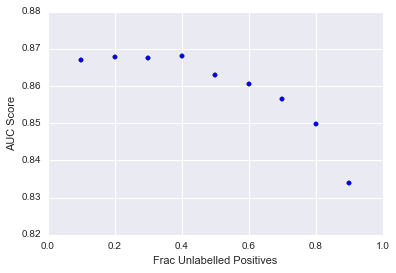

In [22]:
plt.figure()
plt.scatter(gamma_range, auc_results)
plt.ylabel('AUC Score')
plt.xlabel('Frac Unlabelled Positives')